Loaded T2_2000-03.nc with Dask chunks
Loaded I_RAINNC_2000-03.nc with Dask chunks
Loaded RAINNC_2000-03.nc with Dask chunks


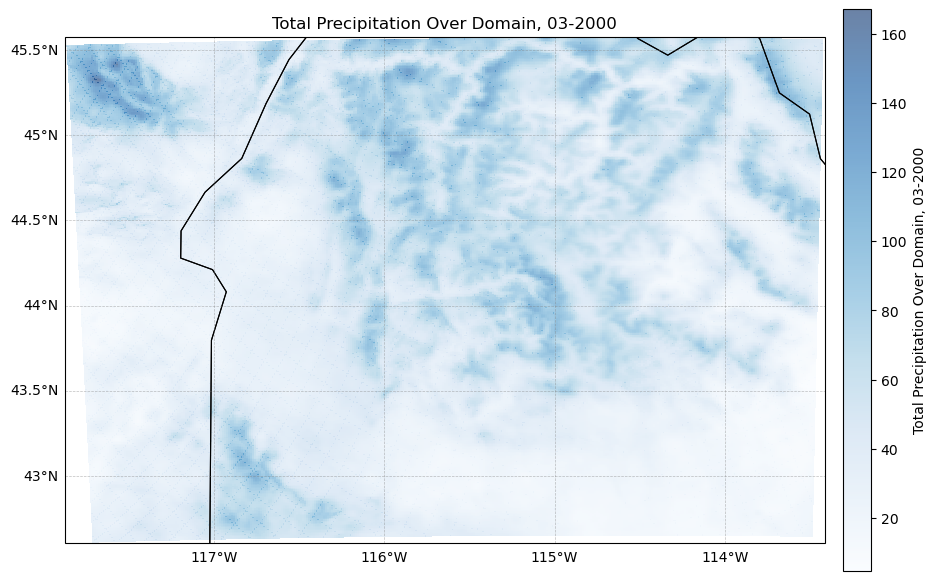

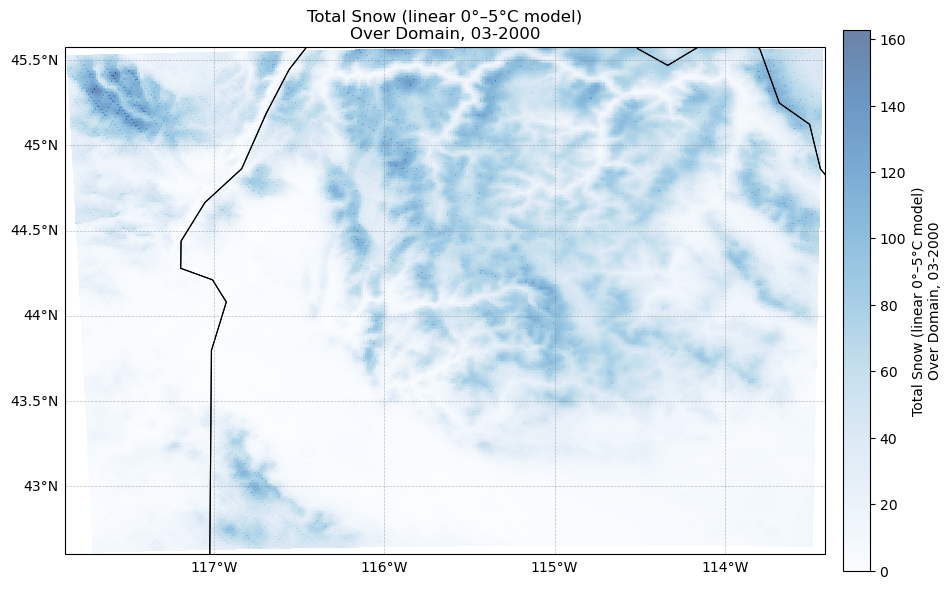

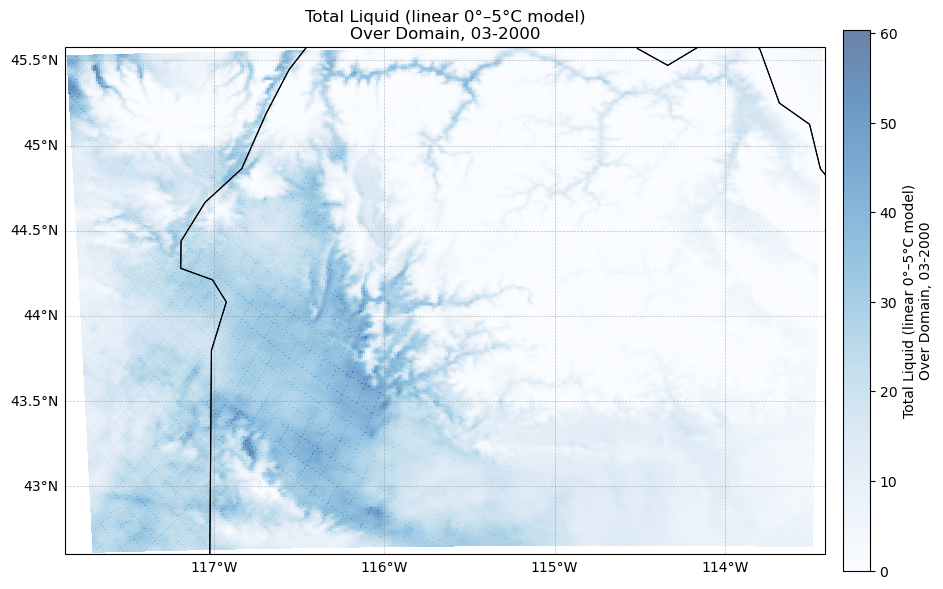

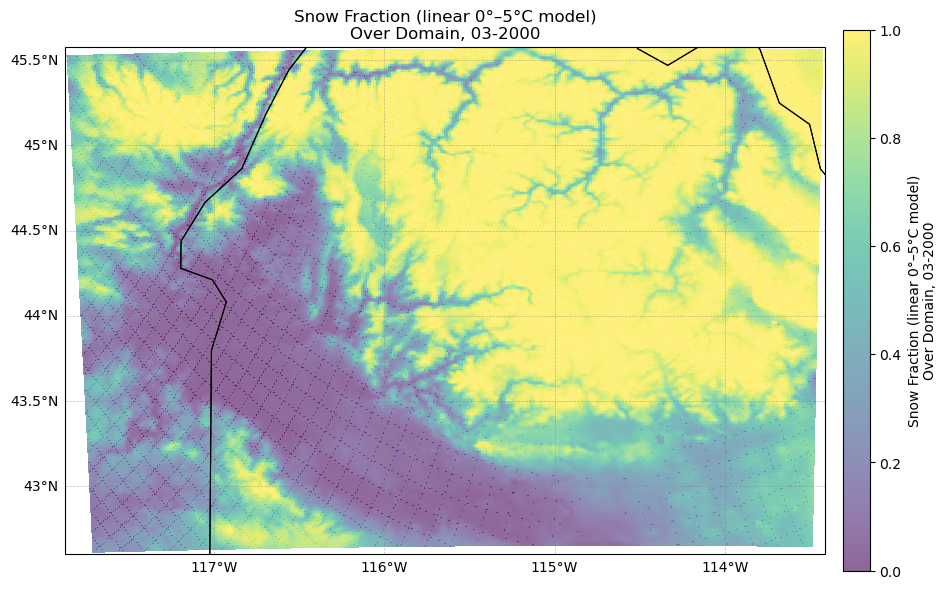

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from importlib import reload
import plot_utils
reload(plot_utils)
from plot_utils import plot_cartopy, load_wrf_var, fix_accum_reset

# === DATA DIRECTORY & CONFIG ===
d02_dir = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d02/"
month, year = "03", "2000"
target_location = "Domain"
min_precip_hr = 0.1 # mm/hr, mask negligible precip in hourly fields
TRAIN_THRESHOLD = 5.0 # °C upper bound
TSNOW_THRESHOLD = 0.0 # °C lower bound
epsilon = 1e-6 # prevent divide by 0

# === LOAD GRID AND ACCUMULATORS ===
t2 = load_wrf_var("T2", d02_dir, year, month)["T2"]
lats = t2["XLAT"][0].values
lons = t2["XLONG"][0].values
count = load_wrf_var("I_RAINNC", d02_dir, year, month)["I_RAINNC"]
rainnc = load_wrf_var("RAINNC", d02_dir, year, month)["RAINNC"]
rainnc = count * 100 + rainnc # fix the 2D accumulation rollover

# === BUILD HOURLY RAIN (mm/hr) ===
raw_precip = rainnc.diff("Time", label="upper").fillna(0)
zero_precip = xr.zeros_like(raw_precip.isel(Time=0))
precip_hourly = xr.concat([zero_precip, raw_precip], dim="Time").transpose("Time","south_north","west_east")
precip_hourly = precip_hourly.where(precip_hourly >= min_precip_hr, 0.0) # mask negligible precip out

# === HOURLY TEMPERATURE IN °C ===
t2_hourly = (t2 - 273.15).transpose("Time","south_north","west_east")

# === LINEAR SNOW FRACTION 0→5 °C ===
span = TRAIN_THRESHOLD - TSNOW_THRESHOLD
snow_frac_linear = xr.where(
 t2_hourly <= TSNOW_THRESHOLD, 1.0,
 xr.where(
 t2_hourly >= TRAIN_THRESHOLD, 0.0,
 (TRAIN_THRESHOLD - t2_hourly) / span
 )
)

# === SPLIT precip_hourly INTO SNOW & LIQUID (linear model) ===
snow_mass_hourly = precip_hourly * snow_frac_linear
liquid_mass_hourly = precip_hourly * (1 - snow_frac_linear)

# === MONTHLY TOTALS (linear model) ===
snow_total_linear = snow_mass_hourly.sum(dim="Time")
liquid_total_linear = liquid_mass_hourly.sum(dim="Time")
precip_total = precip_hourly.sum(dim="Time")

# === DERIVE SNOW FRACTION MAP ===
snow_frac_map = snow_total_linear / (precip_total + epsilon)

# === APPLY MASK ===
mask = precip_total.values < min_precip_hr
precip_ma = np.ma.masked_array(precip_total.values, mask=mask)
snow_ma = np.ma.masked_array(snow_total_linear.values, mask=mask)
liq_ma = np.ma.masked_array(liquid_total_linear.values, mask=mask)
frac_ma = np.ma.masked_array(snow_frac_map.values, mask=mask)

# === PLOTS ===
plot_cartopy(
 lons, lats, precip_ma,
 f"Total Precipitation Over {target_location}, {month}-{year}",
 cmap="Blues"
)
plot_cartopy(
 lons, lats, snow_ma,
 f"Total Snow (linear 0°–5°C model)\nOver {target_location}, {month}-{year}",
 cmap="Blues"
)
plot_cartopy(
 lons, lats, liq_ma,
 f"Total Liquid (linear 0°–5°C model)\nOver {target_location}, {month}-{year}",
 cmap="Blues"
)
plot_cartopy(
 lons, lats, frac_ma,
 f"Snow Fraction (linear 0°–5°C model)\nOver {target_location}, {month}-{year}",
 cmap="viridis", vmin=0, vmax=1
)